[2000 1000  500  200  100   33]


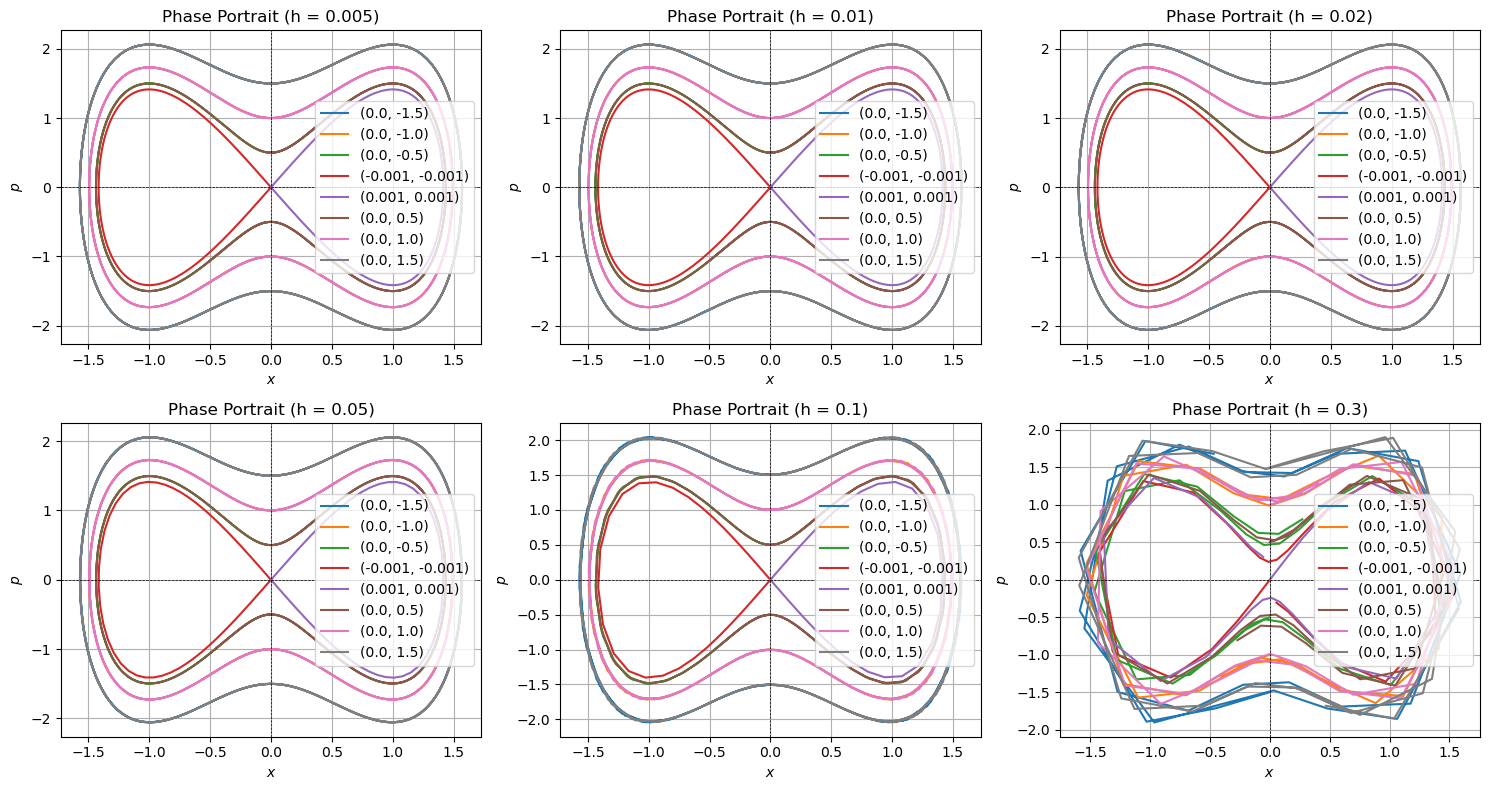

In [443]:
#Week 1
import numpy as np
import matplotlib.pyplot as plt
from fontTools.ttLib.woff2 import pack255UShort


# Define the potential energy function and its derivative
def U(x):
    return (x**2 - 1)**2

def dU_dx(x):
    return 4 * x * (x**2 - 1)  


def verlet(x0, p0, h, steps):
    x = np.zeros(steps)
    p = np.zeros(steps)
    x[0] = x0
    p[0] = p0

    for n in range(steps - 1):
        p_half = p[n] - (h / 2) * dU_dx(x[n]) 
        x[n + 1] = x[n] + h * p_half 
        p[n + 1] = p_half - (h / 2) * dU_dx(x[n + 1])
    return x, p

# Function to plot phase portrait for different time step sizes
def phase_portrait():
    step_sizes = np.array([0.005, 0.01, 0.02, 0.05, 0.1,0.3])
    steps = 10/step_sizes
    steps = np.round(steps).astype(int)
    print(steps)
    
    initial_conditions = [
        (0.0, -1.5), (0.0, -1.0), (0.0, -0.5),
        (-0.001,-0.001),(0.001, 0.001), (0.0, 0.5), (0.0, 1.0),(0.0, 1.5)
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()[:len(step_sizes)]  # Use only necessary axes
    
    for i, h in enumerate(step_sizes):
        ax = axes[i]
        for x0, p0 in initial_conditions:
            x, p = verlet(x0, p0, h, steps[i])
            ax.plot(x, p, label=f"({x0}, {p0})")
        
        ax.set_xlabel("$x$")
        ax.set_ylabel("$p$")
        ax.set_title(f"Phase Portrait (h = {h})")
        ax.axhline(0, color='black', linewidth=0.5, linestyle="--")
        ax.axvline(0, color='black', linewidth=0.5, linestyle="--")
        ax.legend()
        ax.grid()
    
    plt.tight_layout()
    plt.show()

phase_portrait()

In [693]:
#week 2

#Constants and parameters
N = 5#number of particles
epsilon = 100#reduce parameter
sigma = 1#unit nanometer
c = 100#boundary constraint constant
dimension = 2#space dimension of the model
m = 1#mass of molecules

def LJpotential(r):#Lennard-Jones potential
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

def T(p):#Kinetic Energy
    return sum(p[0,:]**2)/(2*m)+sum(p[1,:]**2)/(2*m)

# #def Vb(q):#Additional Potential Function to set a constraint on the spatial boundary of motion
#     r = np.linalg.norm(p)
#     return c*(r/(1-r))**4

def V_LJ(q):#pair potential energy of particle interaction
    V = 0
    for i in range(N):
        for j in range(i+1,N):
            vi = np.array(q[:,i])
            vj = np.array(q[:,j])
            r = np.linalg.norm(vi-vj)#distance between particle i and particle j
            V = V + LJpotential(r)
    return V
    
p1 = np.random.randn(N)
p1 = p1/p1[np.argmax(np.abs(p1))]
p2 = np.random.randn(N)
p2 = p2/p2[np.argmax(np.abs(p2))]
p = np.array([p1,p2])
#
q1 = np.random.randn(N)
q1 = 10*q1/q1[np.argmax(np.abs(q1))]
q2 = np.random.randn(N)
q2 = 10*q2/q2[np.argmax(np.abs(q2))]
q = np.array([q1,q2])
print(V_LJ(q))
print(T(p))
H = T(p) + V_LJ(q)
# print(T(p))
# print(V_LJ(q))
# print(Vb(q))
# print("--------Hamiltonian----------")
# print(H)

-0.004133006892269069
1.6202197082600311


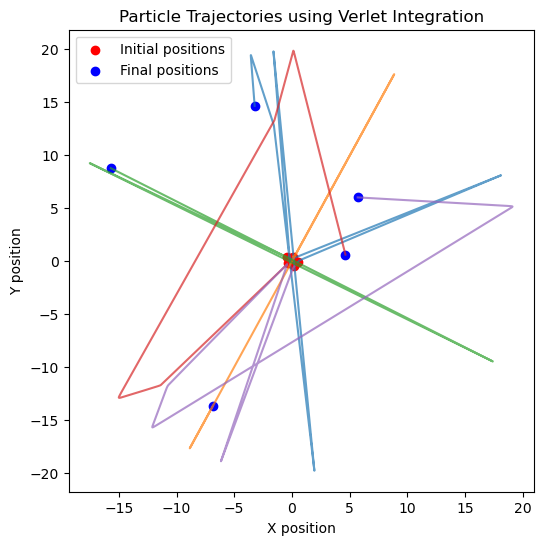

4418

In [723]:
def interaction_force(qi,qj):
    v = qi-qj
    r = np.linalg.norm(qi-qj)
    if r == 0:  # Avoid division by zero
        return -np.ones(dimension)*10
    dVr = 4*epsilon*(-12*sigma**12*r**(-13)+6*sigma**6*r**(-7))
    F = np.zeros(2)
    F[0] = -dVr*v[0]/r
    F[1] = -dVr*v[1]/r
    return F/100

def confinement_force(q):
    r = np.linalg.norm(q)
    if r >= 20:
        r = 19
    if r < 15:
        return np.zeros(dimension)
    f = -c*(1/(20-r))**4#force magnitude
    n = q/np.linalg.norm(q)#unit vector of force direction
    return f*n

# Compute total forces on each particle
def compute_forces(q):
    forces = np.zeros((dimension, N))
    
    # Lennard-Jones interaction forces
    for i in range(N):
        for j in range(i + 1, N):
            F_ij = interaction_force(q[:, i], q[:, j])
            forces[:, i] += F_ij
            forces[:, j] -= F_ij  # Newton's Third Law
    
    # Confinement forces
    for i in range(N):
        forces[:, i] += confinement_force(q[:, i])

    return forces

# Initialize positions in a circular distribution
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
q = np.zeros((dimension, N))
q[0, :] = 0.5 * np.cos(angles+0.1)
q[1, :] = 0.5 * np.sin(angles-0.2)

plt.figure(figsize=(6, 6))
plt.scatter(q[0, :], q[1, :], color='red', label="Initial positions")

# Initialize velocities randomly
p = -np.random.randn(dimension, N)/100

# Initialize forces
F = compute_forces(q)

num_steps = 10000
dt = 0.0001

# Store positions for visualization
trajectory = np.zeros((num_steps, dimension, N))

# Verlet integration loop
for step in range(num_steps):
    # Store current positions
    trajectory[step] = q
    # Compute new forces
    F = compute_forces(q)
    
    # Verlet position update1
    p = p + 0.5 * F * dt

    # Verlet velocity update
    q += dt*p
    F = compute_forces(q)
    
    # Verlet position update2
    p = p + 0.5 * F *dt
    

# Visualization of trajectory
for i in range(N):
    plt.plot(trajectory[:, 0, i], trajectory[:, 1, i], alpha=0.7)

plt.scatter(q[0, :], q[1, :], color='blue', label="Final positions")
plt.title("Particle Trajectories using Verlet Integration")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.legend()
plt.show()

import gc
q = None
p = None
F = None
trajectory = None
gc.collect()